## Goal: Predict if a loan was good or bad
## Metric:  Percentage of loans correctly predicted using classification accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

%matplotlib inline

### Helper Methods

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def standardize(data):
    from sklearn.preprocessing import StandardScaler
    # Get all numeric features
    numerical_features = []
    for feature in data.dtypes.index:
        if (data[feature].dtype != np.object):
            numerical_features.append(feature)

    data[numerical_features] = data[numerical_features].fillna(0)
    
    scaler = StandardScaler()
    data[numerical_features]= scaler.fit_transform(data[numerical_features])
    standard_data = data
    
    return standard_data

def ohe(data,category):
    data_dummies = pd.get_dummies(data[category])
    data = data.drop(category,axis=1)
    data = pd.concat([data, data_dummies],axis=1)
    
    return data

def get_train_test(data):
    
    # Get test set from data
    test_data = data[data['good_bad_flag'].isnull()].reset_index()
    test_data = test_data.drop('index',axis=1)
    
    
    # Get train set from data
    data_train_g = data[data['good_bad_flag'] == 'Good'].reset_index()
    
    # data_10k_train_g = data_10k_train.drop('index',axis=1)

    data_train_b = data[data['good_bad_flag'] == 'Bad'].reset_index()
    # data_10k_train_b = data_10k_train.drop('index',axis=1)

    frames = [data_train_g,data_train_b]
    train_data = pd.concat(frames)

    train_data = train_data.drop('index',axis=1)

    from sklearn.preprocessing import LabelEncoder
    lb_make = LabelEncoder()

    # Get train & test set from the 
    train_data['good_bad_flag'] = lb_make.fit_transform(train_data['good_bad_flag'])
    
    return train_data,test_data

def get_x_y(data): 
    data = data.iloc[:,data.columns != "customerid"]

    Y = data.iloc[:,data.columns =="good_bad_flag"]

    X = data.iloc[:,data.columns != "good_bad_flag"]
    X = X.iloc[:,X.columns != "loanamount"]
    
    return X,Y

# 1. Performance 
Dataset containing all loans disbursed over a period of time with the corresponding outcome (Repaid or not)

In [3]:
train_perf = pd.read_csv('trainperf.csv.xls')
test_perf = pd.read_csv('testperf.csv.xls')
frames = [train_perf,test_perf]
perf = pd.concat(frames)
perf.shape

(5818, 10)

In [4]:
print(train_perf.shape,test_perf.shape)

(4368, 10) (1450, 9)


In [5]:
perf.head()

,approveddate,creationdate,customerid,good_bad_flag,loanamount,loannumber,referredby,systemloanid,termdays,totaldue
0,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,8a2a81a74ce8c05d014cfb32a0da1049,Good,30000.0,12,NaN,301994762,30,34500.0
1,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,8a85886e54beabf90154c0a29ae757c0,Good,15000.0,2,NaN,301965204,30,17250.0
2,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,8a8588f35438fe12015444567666018e,Good,20000.0,7,NaN,301966580,15,22250.0
3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,8a85890754145ace015429211b513e16,Good,10000.0,3,NaN,301999343,15,11500.0
4,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,8a858970548359cc0154883481981866,Good,40000.0,9,NaN,301962360,30,44000.0


### 1.1 Loan Amount 

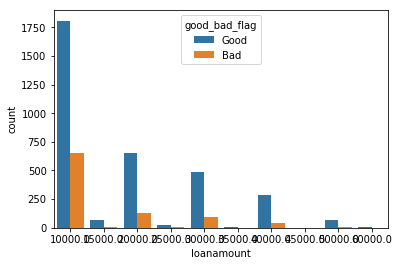

In [6]:
sns.countplot(x='loanamount',hue='good_bad_flag',data=train_perf);

## Since loan amount of 10,0000 has most of the bad loans we divide the models into two (10k and others)

### 1.2 Term Days

### 10k

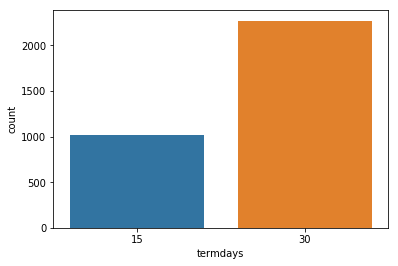

In [7]:
sns.countplot(x='termdays',data=perf[perf['loanamount']==10000.0]);

### others

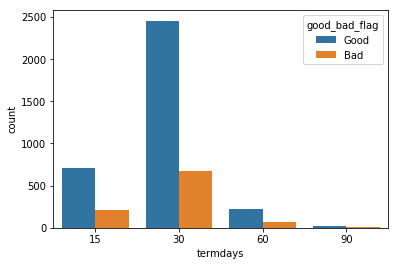

In [8]:
sns.countplot(x='termdays',data=train_perf, hue='good_bad_flag');

In [9]:
others_termdays = train_perf[['termdays','good_bad_flag','loanamount']][train_perf['loanamount']!=10000.0]
others_termdays
term_days_count = others_termdays['termdays'].value_counts()

In [10]:
# 15 term days
fifteen_term = others_termdays[['termdays','good_bad_flag']][train_perf['termdays']==15 ]
print ( 'Percentage of bad loans for 15 term days is: ' + str((fifteen_term[fifteen_term['good_bad_flag']=='Bad'].shape[0] / term_days_count.loc[15]) * 100))

# 30 term days
thirty_term = others_termdays[['termdays','good_bad_flag']][train_perf['termdays']==30 ]
print ( 'Percentage of bad loans for 30 term days is: ' + str((thirty_term[thirty_term['good_bad_flag']=='Bad'].shape[0] / term_days_count.loc[30]) * 100))

# 60 term days
sixty_term = others_termdays[['termdays','good_bad_flag']][train_perf['termdays']==60 ]
print ( 'Percentage of bad loans for 60 term days is: ' + str((sixty_term[sixty_term['good_bad_flag']=='Bad'].shape[0] / term_days_count.loc[60]) * 100))

# 90 term days
ninety_term = others_termdays[['termdays','good_bad_flag']][train_perf['termdays']==90 ]
print ( 'Percentage of bad loans for 90 term days is: ' + str((ninety_term[ninety_term['good_bad_flag']=='Bad'].shape[0] / term_days_count.loc[90] ) * 100))



Percentage of bad loans for 15 term days is: 20.3703703704
Percentage of bad loans for 30 term days is: 13.5533707865
Percentage of bad loans for 60 term days is: 22.5694444444
Percentage of bad loans for 90 term days is: 18.75


/Users/femi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/femi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/femi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/femi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### So there is no progression in the percentage of bad loans as term days increases, so we convert to a categorical variable.

In [11]:
# Convert termdays into categorical variable
perf['termdays'] = perf['termdays'].apply(lambda x : 'fifteen' if x==15 else 'thirty' if x==30 else 'sixty' if x==60 else 'ninety')

In [12]:
# Sanity Check
perf['termdays'].unique()

array(['thirty', 'fifteen', 'sixty', 'ninety'], dtype=object)

In [13]:
data = perf

### 1.3 Referred by
Convert to binary variable (Indicates whether a customer was referred or not)

In [14]:
data['referredby'] = data['referredby'].fillna(0)
data['referred'] = data['referredby'].apply(lambda x : 0 if x==0 else 1)

### 1.4 Interest (Total due - Loan amount)

In [15]:
data['interest'] = data['totaldue'] - data['loanamount']
data.head()

,approveddate,creationdate,customerid,good_bad_flag,loanamount,loannumber,referredby,systemloanid,termdays,totaldue,referred,interest
0,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,8a2a81a74ce8c05d014cfb32a0da1049,Good,30000.0,12,0,301994762,thirty,34500.0,0,4500.0
1,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,8a85886e54beabf90154c0a29ae757c0,Good,15000.0,2,0,301965204,thirty,17250.0,0,2250.0
2,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,8a8588f35438fe12015444567666018e,Good,20000.0,7,0,301966580,fifteen,22250.0,0,2250.0
3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,8a85890754145ace015429211b513e16,Good,10000.0,3,0,301999343,fifteen,11500.0,0,1500.0
4,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,8a858970548359cc0154883481981866,Good,40000.0,9,0,301962360,thirty,44000.0,0,4000.0


In [16]:
data['loannumber'].unique()

array([12,  2,  7,  3,  9,  8, 10,  4, 11, 13, 15,  5,  6, 17, 18, 14, 22,
       16, 19, 27, 20, 21, 23, 34])

In [17]:
data['loannumber'] = data['loannumber'].fillna(0)

# 2. Demographics
Dataset containing demographic information on customers

In [18]:
train_demographics = pd.read_csv('traindemographics.csv.xls')
test_demographics = pd.read_csv('testdemographics.csv.xls')
frames = [train_demographics,test_demographics]

# Combine train & test
demographics = pd.concat(frames)
demographics.shape

(5833, 9)

In [19]:
print(train_demographics.shape,test_demographics.shape)

(4346, 9) (1487, 9)


In [20]:
len(demographics['customerid'].unique())

5818

### Seems we are on the right track as number of unique customers in the demographics data (5818) is the same as the performance data (5818)

### Drop Duplicates

In [21]:
demographics = demographics.drop_duplicates(subset='customerid',keep='last')

In [22]:
demographics.shape

(5818, 9)

### 2.1 Age
### Calculate age ( Date the loans were disbursed - Date of Birth)
** To keep it simple I used 2017-07-01 as the date the loans were disbursed because all the loans were disbursed in the same month but different days.**

In [23]:
# Pop off '00:00:00.000000' from birthdate
demographics['age'] = demographics['birthdate'].apply(lambda x: x.split().pop(0)[:10])
# Sanity Check
demographics['age'].head()

0    1973-10-10
1    1986-01-21
2    1987-04-01
3    1991-07-19
4    1982-11-22
Name: age, dtype: object

In [24]:
# Split the birth date (This converts each observation into a list)
demographics['age'] = demographics['age'].apply(lambda x: x.split('-'))

# Convert all elements in each observation(list) from str to int
demographics['age'] = demographics['age'].apply(lambda x: [int(y) for y in x ])

# Convert each observation into a date format
demographics['age'] = demographics['age'].apply(lambda x : date(x[0], x[1], x[2]))

# Calculate Age!
demographics['age'] = demographics['age'].apply(lambda x:(date(2017,7,1) - x) // timedelta(days=365.2425) )

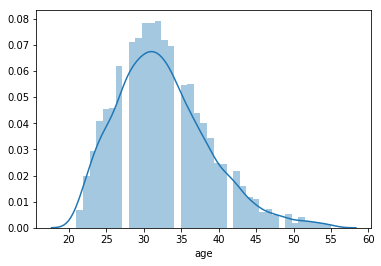

In [25]:
sns.distplot((demographics['age']))

In [26]:
demographics = demographics.drop('birthdate',axis=1)
demographics.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,43
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,31
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,30
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,25
4,8a858e785acd3412015acd48f4920d04,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,34


### Missing Values

In [27]:
missing = demographics.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame(missing, columns = ['Missing'])
missing_table = missing_df[missing_df.Missing > 0]
missing_table

,Missing
bank_branch_clients,5753
level_of_education_clients,5023
employment_status_clients,865


### Go ahead to delete the first two variables in the table above, because they have way too many missing values.

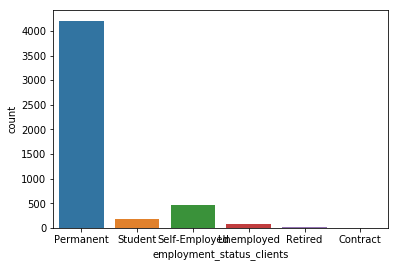

In [28]:
demographics = demographics.drop('level_of_education_clients',axis=1)
demographics = demographics.drop('bank_branch_clients',axis=1)
sns.countplot(demographics['employment_status_clients']);

In [29]:
demographics.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,GT Bank,NaN,43
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Sterling Bank,Permanent,31
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,Fidelity Bank,NaN,30
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,GT Bank,Permanent,25
4,8a858e785acd3412015acd48f4920d04,Savings,8.455332,11.971410,GT Bank,Permanent,34


Deal with 'employment_status_clients' later

In [30]:
# Merge the demographics data with the performance data (data)
data = pd.merge(data, demographics, how='outer', on=['customerid'])
data.head()

,approveddate,creationdate,customerid,good_bad_flag,loanamount,loannumber,referredby,systemloanid,termdays,totaldue,referred,interest,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age
0,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,8a2a81a74ce8c05d014cfb32a0da1049,Good,30000.0,12,0,301994762,thirty,34500.0,0,4500.0,Other,3.432010,6.433055,Diamond Bank,Permanent,45
1,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,8a85886e54beabf90154c0a29ae757c0,Good,15000.0,2,0,301965204,thirty,17250.0,0,2250.0,Savings,3.885298,7.320700,GT Bank,Permanent,31
2,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,8a8588f35438fe12015444567666018e,Good,20000.0,7,0,301966580,fifteen,22250.0,0,2250.0,Other,11.139350,10.292041,EcoBank,Permanent,32
3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,8a85890754145ace015429211b513e16,Good,10000.0,3,0,301999343,fifteen,11500.0,0,1500.0,Savings,3.985770,7.491708,First Bank,Permanent,39
4,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,8a858970548359cc0154883481981866,Good,40000.0,9,0,301962360,thirty,44000.0,0,4000.0,Other,7.457913,9.076574,GT Bank,Permanent,30


# 3. Previous Loans
Dataset containing information about previous loans customers applied for prior to applying for the current loan. 

In [31]:
train_prevloans = pd.read_csv('trainprevloans.csv.xls')
test_prevloans = pd.read_csv('testprevloans.csv.xls')
frames = [train_prevloans,test_prevloans]
previous_loans = pd.concat(frames)
previous_loans.shape

(24090, 12)

In [32]:
previous_loans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


### 3.2 Average Loan Amount, Average Interest & Average Termdays for each customer

### Generating new features using data on previous loans


In [33]:
previous_loans[['customerid','loanamount','totaldue']]
grouped = previous_loans[['customerid','loanamount','totaldue']].groupby('customerid').mean()
grouped = grouped.reset_index()
grouped.columns = ['customerid','avg_loanamount','avg_totaldue']
grouped.head()

,customerid,avg_loanamount,avg_totaldue
0,8a1088a0484472eb01484669e3ce4e0b,10000.000000,11500.000000
1,8a1a1e7e4f707f8b014f797718316cad,17500.000000,22375.000000
2,8a1a32fc49b632520149c3b8fdf85139,12857.142857,15214.285714
3,8a1eb5ba49a682300149c3c068b806c7,16250.000000,20300.000000
4,8a1edbf14734127f0147356fdb1b1eb2,10000.000000,12250.000000


In [34]:
grouped = grouped[['customerid','avg_loanamount','avg_totaldue']]

In [35]:
data = pd.merge(data, grouped, how='outer', on=['customerid'])

In [36]:
data[['avg_loanamount','avg_totaldue']] = data[['avg_loanamount','avg_totaldue']].fillna(0)

In [37]:
data['avg_interest'] = data['avg_totaldue'] - data['avg_loanamount']

In [38]:
data.head()

,approveddate,creationdate,customerid,good_bad_flag,loanamount,loannumber,referredby,systemloanid,termdays,totaldue,...,interest,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,age,avg_loanamount,avg_totaldue,avg_interest
0,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,8a2a81a74ce8c05d014cfb32a0da1049,Good,30000.0,12,0,301994762,thirty,34500.0,...,4500.0,Other,3.432010,6.433055,Diamond Bank,Permanent,45,18181.818182,22081.818182,3900.0
1,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,8a85886e54beabf90154c0a29ae757c0,Good,15000.0,2,0,301965204,thirty,17250.0,...,2250.0,Savings,3.885298,7.320700,GT Bank,Permanent,31,0.000000,0.000000,0.0
2,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,8a8588f35438fe12015444567666018e,Good,20000.0,7,0,301966580,fifteen,22250.0,...,2250.0,Other,11.139350,10.292041,EcoBank,Permanent,32,10000.000000,11750.000000,1750.0
3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,8a85890754145ace015429211b513e16,Good,10000.0,3,0,301999343,fifteen,11500.0,...,1500.0,Savings,3.985770,7.491708,First Bank,Permanent,39,10000.000000,12250.000000,2250.0
4,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,8a858970548359cc0154883481981866,Good,40000.0,9,0,301962360,thirty,44000.0,...,4000.0,Other,7.457913,9.076574,GT Bank,Permanent,30,18750.000000,23550.000000,4800.0


### 3.3 Repayment Score (First due date - First Repaid date)

# Repayment score can be seen as how long it takes you to repay a loan in reference to the due date. Defaulters have a negative repayment score.

In [40]:
previous_loans['firstduedate'] = previous_loans['firstduedate'].apply(lambda x: x.split().pop(0)[:10])
previous_loans['firstrepaiddate'] = previous_loans['firstrepaiddate'].apply(lambda x: x.split().pop(0)[:10])

In [41]:
# Split the  date (This converts each observation into a list)
previous_loans['firstduedate'] = previous_loans['firstduedate'].apply(lambda x: x.split('-'))

# Convert all elements in each observation(list) from str to int
previous_loans['firstduedate'] = previous_loans['firstduedate'].apply(lambda x: [int(y) for y in x ])

# Convert each observation into a date format
previous_loans['firstduedate'] = previous_loans['firstduedate'].apply(lambda x : date(x[0], x[1], x[2]))

# Split the  date (This converts each observation into a list)
previous_loans['firstrepaiddate'] = previous_loans['firstrepaiddate'].apply(lambda x: x.split('-'))

# Convert all elements in each observation(list) from str to int
previous_loans['firstrepaiddate'] = previous_loans['firstrepaiddate'].apply(lambda x: [int(y) for y in x ])

# Convert each observation into a date format
previous_loans['firstrepaiddate'] = previous_loans['firstrepaiddate'].apply(lambda x : date(x[0], x[1], x[2]))

# Calculate repayment_score
previous_loans['repayment_score'] = previous_loans['firstduedate'] - previous_loans['firstrepaiddate']


In [42]:
previous_loans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,repayment_score
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14,2016-09-01,13 days
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30,2017-05-26,4 days
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04,2017-04-26,-22 days
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24,2017-04-24,0 days
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03,2017-07-14,-11 days


In [43]:
previous_loans['repayment_score'] = previous_loans['repayment_score'].astype('str').apply(lambda x: int(x.strip(' ')[:2]))

In [44]:
previous_loans[['customerid','repayment_score']]
grouped = previous_loans[['customerid','repayment_score']].groupby('customerid').sum()
grouped = grouped.reset_index()
grouped.shape

(5801, 2)

In [45]:
data = pd.merge(data, grouped, how='outer', on=['customerid'])

In [46]:
data['repayment_score'] = data['repayment_score'].fillna(0)

### Missing Data (employment_status_clients)

In [47]:
data['employment_status_clients'].isnull().sum()

865

In [48]:
data['employment_status_clients'] = data['employment_status_clients'].fillna(method='bfill')
data['employment_status_clients'].isnull().sum()

0

In [49]:
data.shape

(5818, 22)

# 4. Feature Engineering

In [50]:
data['loan_deviation'] = data['avg_loanamount'] - data['loanamount']

### Drop Some Irrelevant Features (for now)

In [51]:
data = data.drop(['referredby','longitude_gps','latitude_gps','bank_name_clients','approveddate','creationdate','systemloanid'],axis=1)

# 5. Data Pre-Processing

## Split dataset into two (10k and others) as stated earlier in section 1. 

In [52]:
data_10k = data[data['loanamount'] == 10000.0]
data_others = data[data['loanamount']!=10000.0]
print (data_10k.shape)
print (data_others.shape)

(3287, 16)
(2531, 16)


### Standardization

In [53]:
data_10k_standard = standardize(data_10k)
data_others_standard = standardize(data_others)

/Users/femi/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/femi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/femi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

### Encoding non numerical data

#### One Hot Encoding of bank_account_type, termdays & employment_status_clients

In [54]:
category = ['bank_account_type','employment_status_clients','termdays']

data_10k = ohe(data_10k_standard,category)
data_others = ohe(data_others_standard,category)

# data_10k

In [55]:
data_10k_train, data_10k_test = get_train_test(data_10k)

# data_others

In [68]:
data_others_train, data_others_test = get_train_test(data_others)

### Showing the ratio of classes

Percentage of good loans:  0.2660438667749797
Percentage of bad loans:  0.7339561332250203
Total number of loans in data:  2462


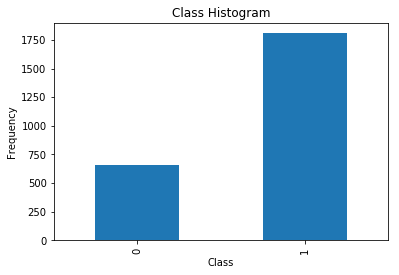

In [56]:
count_of_classes = pd.value_counts(data_10k_train['good_bad_flag'], sort = True).sort_index()
count_of_classes.plot(kind = 'bar')
plt.title("Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Showing ratio
print("Percentage of good loans: ", len(data_10k_train[data_10k_train['good_bad_flag'] == 0])/len(data_10k_train))
print("Percentage of bad loans: ", len(data_10k_train[data_10k_train['good_bad_flag'] == 1])/len(data_10k_train))
print("Total number of loans in data: ", len(data_10k_train))

### Split into Features and Target ( X & Y )

In [57]:
X,Y = get_x_y(data_10k_train)


In [58]:
X.columns

Index(['loannumber', 'totaldue', 'referred', 'interest', 'age',
       'avg_loanamount', 'avg_totaldue', 'avg_interest', 'repayment_score',
       'loan_deviation', 'bank_account_type_Current',
       'bank_account_type_Other', 'bank_account_type_Savings',
       'employment_status_clients_Contract',
       'employment_status_clients_Permanent',
       'employment_status_clients_Retired',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student',
       'employment_status_clients_Unemployed', 'termdays_fifteen',
       'termdays_thirty'],
      dtype='object')

# 6. Building the prediction model (data_10k model)

CV score    : 0.735171259421
Train score : 0.760301799187
Test Score  : 0.745602165088


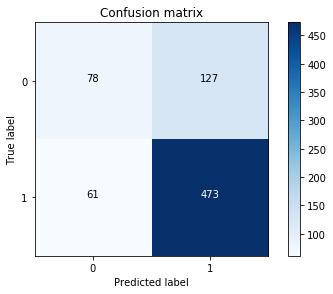

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier


import itertools

# Cross Validation
model = DecisionTreeClassifier(max_depth=4)

score = cross_val_score(model,X,Y,cv=5,scoring='accuracy')

# Train & Test scores for bias variance tradeoff
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)
model.fit(X_train,Y_train)

model.fit(X,Y)

pred = model.predict(X_test)

print('CV score    : '+ str(score.mean()))
print('Train score : ' + str(model.score(X_train,Y_train)))
print('Test Score  : ' + str(model.score(X_test,Y_test)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [60]:
submission_X, submission_Y = get_x_y(data_10k_test)

In [61]:
submission_1 = pd.DataFrame(data_10k_test['customerid'])

In [62]:
submission_1.shape

(825, 1)

In [63]:
pred = model.predict(submission_X)

In [64]:
submission_1['Good_Bad_flag'] = pred

# 6.1 data_others model

In [71]:
data_others_train, data_others_test = get_train_test(data_others)
submission_X, submission_Y = get_x_y(data_others)

### Split into Features and Target ( X & Y )

In [72]:
X,Y = get_x_y(data_others_train)

CV score    : 0.828443581849
Train score : 0.853823088456
Test Score  : 0.839160839161


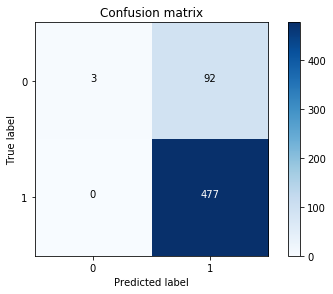

In [73]:
# Cross Validation
model = DecisionTreeClassifier(max_depth=4)

score = cross_val_score(model,X,Y,cv=5,scoring='accuracy')

# Train & Test scores for bias variance tradeoff
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)
model.fit(X_train,Y_train)

model.fit(X,Y)

pred = model.predict(X_test)

print('CV score    : '+ str(score.mean()))
print('Train score : ' + str(model.score(X_train,Y_train)))
print('Test Score  : ' + str(model.score(X_test,Y_test)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [75]:
submission_X, submission_Y = get_x_y(data_others_test)

In [76]:
submission_2 = pd.DataFrame(data_others_test['customerid'])

In [77]:
submission_2.shape

(625, 1)

In [78]:
pred = model.predict(submission_X)

In [ ]:
submission_1['Good_Bad_flag'] = pred

# 6.2 Create Submission File

In [79]:
frames = [submission_1,submission_2]
submission = pd.concat(frames)

In [80]:
submission.to_csv('submission.csv')

In [81]:
submission.shape

(1450, 2)